# Fine Tuning Transformer for Summary Generation


### Introduction

In this tutorial we will be fine tuning a transformer model for **Summarization Task**.
In this task a summary of a given article/document is generated when passed through a network. There are 2 types of summary generation mechanisms:

1. ***Extractive Summary:*** the network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.
2. ***Abstractive Summary***: The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article.

In this tutorial we will be generating ***Abstractive Summary***.

#### Flow of the notebook

* As with all the tutorials previously, this notebook also follows a easy to follow steps. Making the process of fine tuning and training a Transformers model a straight forward task.
* However, unlike the other notebooks, in the tutorial, most of the sections have been created into functions, and they are called from the `main()` in the end of the notebook.
* This is done to leverage the [Weights and Biases Service](https://www.wandb.com/) WandB in short.
* It is a experiment tracking, parameter optimization and artifact management service. That can be very easily integrated to any of the Deep learning or Machine learning frameworks.

The notebook will be divided into separate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Preparing Environment and Importing Libraries](#section01)
2. [Preparing the Dataset for data processing: Class](#section02)
3. [Fine Tuning the Model: Function](#section03)
4. [Validating the Model Performance: Function](#section04)
5. [Main Function](#section05)
    * [Initializing WandB](#section501)
    * [Importing and Pre-Processing the domain data](#section502)
    * [Creation of Dataset and Dataloader](#section503)
    * [Neural Network and Optimizer](#section504)
    * [Training Model and Logging to WandB](#section505)
    * [Validation and generation of Summary](#section506)
6. [Examples of the Summary Generated from the model](#section06)


#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

- **Data**:
	- We are using the News Summary dataset available at [Kaggle](https://www.kaggle.com/sunnysai12345/news-summary)
	- This dataset is the collection created from Newspapers published in India, extracting, details that are listed below.  We are referring only to the first csv file from the data dump: `news_summary.csv`
	- There are`4514` rows of data.  Where each row has the following data-point:
		- **author** : Author of the article
		- **date** : Date the article was published
		- **headline**: Headline for the published article
		- **read_more** : URL for the article to follow online
		- **text**: This is the summary of the article
		- **ctext**: This is the complete article


- **Language Model Used**:
    - This notebook uses one of the most recent and novel transformers model ***T5***. [Research Paper](https://arxiv.org/abs/1910.10683)    
    - ***T5*** in many ways is one of its kind transformers architecture that not only gives state of the art results in many NLP tasks, but also has a very radical approach to NLP tasks.
    - **Text-2-Text** - According to the graphic taken from the T5 paper. All NLP tasks are converted to a **text-to-text** problem. Tasks such as translation, classification, summarization and question answering, all of them are treated as a text-to-text conversion problem, rather than seen as separate unique problem statements.
    - **Unified approach for NLP Deep Learning** - Since the task is reflected purely in the text input and output, you can use the same model, objective, training procedure, and decoding process to ANY task. Above framework can be used for any task - show Q&A, summarization, etc.
   - We will be taking inputs from the T5 paper to prepare our dataset prior to fine tuning and training.    
   - [Documentation for python](https://huggingface.co/transformers/model_doc/t5.html)

![**Each NLP problem as a “text-to-text” problem** - input: text, output: text](https://miro.medium.com/max/4006/1*D0J1gNQf8vrrUpKeyD8wPA.png)



- Hardware Requirements:
	- Python 3.6 and above
	- Pytorch, Transformers and
	- All the stock Python ML Library
	- GPU enabled setup
   

- **Script Objective**:
	- The objective of this script is to fine tune ***T5 *** to be able to generate summary, that a close to or better than the actual summary  while ensuring the important information from the article is not lost.

---
NOTE:
We are using the Weights and Biases Tool-set in  this tutorial. The different components will be explained as we go through the article.

<a id='section01'></a>
### Preparing Environment and Importing Libraries

At this step we will be installing the necessary libraries followed by importing the libraries and modules needed to run our script.
We will be installing:
* transformers
* wandb

Libraries imported are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* T5 Model and Tokenizer
* wandb

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU. First we will check the GPU avaiable to us, using the nvidia command followed by defining our device.

Finally, we will be logging into the [wandb](https://www.wandb.com/) serice using the login command

In [1]:
!pip install transformers -q
!pip install wandb -q

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install sentencepiece



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import sentencepiece

In [2]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

In [3]:
# Checking out the GPU we have access to. This is output is from the google colab version.
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [3]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [4]:
# Login to wandb to log the model run and all the parameters
!wandb login ee4907d763a4597ffac27fd570e8489a92f2cf5e

wandb: Appending key for api.wandb.ai to your netrc file: /Users/pepperhome/.netrc


<a id='section02'></a>
### Preparing the Dataset for data processing: Class

We will start with creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. This dataset will be used the the Dataloader method that will feed  the data in batches to the neural network for suitable training and processing.
The Dataloader and Dataset will be used inside the `main()`.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the **T5** model for training.
- We are using the **T5** tokenizer to tokenize the data in the `text` and `ctext` column of the dataframe.
- The tokenizer uses the ` batch_encode_plus` method to perform tokenization and generate the necessary outputs, namely: `source_id`, `source_mask` from the actual text and `target_id` and `target_mask` from the summary text.
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/t5.html#t5tokenizer)
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader: Called inside the `main()`
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of data loaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [5]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.ctext = self.data.ctext

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long),
            'source_mask': source_mask.to(dtype=torch.long),
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

<a id='section03'></a>
### Fine Tuning the Model: Function

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

This function is called in the `main()`

Following events happen in this function to fine tune the neural network:
- The epoch, tokenizer, model, device details, testing_ dataloader and optimizer are passed to the `train ()` when its called from the `main()`
- The dataloader passes data to the model based on the batch size.
- `language_model_labels` are calculated from the `target_ids` also, `source_id` and `attention_mask` are extracted.
- The model outputs first element gives the loss for the forward pass.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 10 steps the loss value is logged in the wandb service. This log is then used to generate graphs for analysis. Such as [these](https://app.wandb.ai/abhimishra-91/transformers_tutorials_summarization?workspace=user-abhimishra-91)
- After every 500 steps the loss value is printed in the console.

In [6]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        #outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)

        loss = outputs[0]

        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

<a id='section04'></a>
### Validating the Model Performance: Function

During the validation stage we pass the unseen data(Testing Dataset), trained model, tokenizer and device details to the function to perform the validation run. This step generates new summary for dataset that it has not seen during the training session.

This function is called in the `main()`

This unseen data is the 20% of `news_summary.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. We use the generate method for generating new text for the summary.

It depends on the `Beam-Search coding` method developed for sequence generation for models with LM head.

The generated text and originally summary are decoded from tokens to text and returned to the `main()`

In [7]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                #max_length=150,
                max_length=30,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [8]:
def concat_fields(row):
    if row['Sub-issue'] == 'None':
        return row['Issue']
    else:
        return row['Issue'] + ', ' + row['Sub-issue']

read_df = pd.read_csv('data/complaints1.csv',encoding='latin-1')
read_df['text'] = read_df.apply(concat_fields, axis=1)
read_df = read_df.rename(columns={'Consumer complaint narrative': 'ctext'})


df = read_df[['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'text', 'ctext']]


df.to_csv('data/complaints1_prepped.csv', index=False)


/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/2577752228.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(lambda x: len(str(x)))


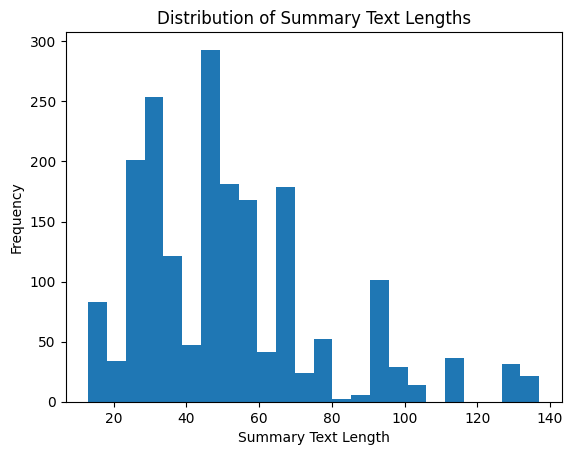

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'ctext' is your text column
# df = pd.DataFrame(...)

# Calculate the length of each text in the 'ctext' column
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

# Plot the distribution of text lengths
plt.hist(df['text_length'], bins='auto') # 'auto' allows matplotlib to choose the number of bins optimally
plt.title('Distribution of Summary Text Lengths')
plt.xlabel('Summary Text Length')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Sort the DataFrame by 'text_length' in descending order and select the top 5 rows
top_5_rows = df.sort_values('text_length', ascending=False).head(5)

pd.set_option('display.max_colwidth', -1)
top_5_rows[['text', 'text_length']]

/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/1972321798.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,text,text_length
658,"Problem with a credit reporting company's investigation into an existing problem, Their investigation did not fix an error on your report",137
165,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",136
1249,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",136
1581,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",136
1451,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",136


/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/1669417454.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_tokens'] = df['text'].apply(lambda x: len(str(x).split()))


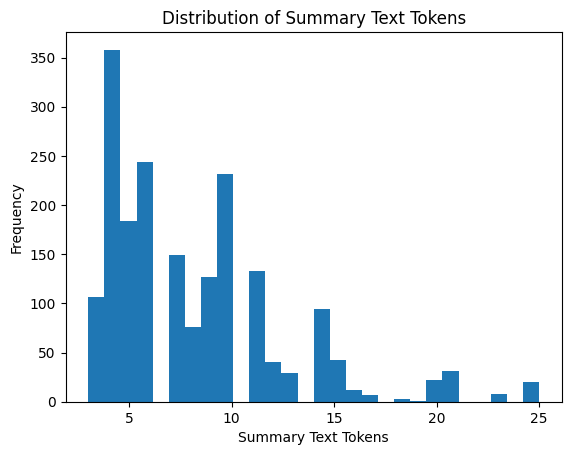

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'ctext' is your text column
# df = pd.DataFrame(...)

# Calculate the number of tokens in each text in the 'ctext' column
df['num_tokens'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of text lengths
plt.hist(df['num_tokens'], bins='auto') # 'auto' allows matplotlib to choose the number of bins optimally
plt.title('Distribution of Summary Text Tokens')
plt.xlabel('Summary Text Tokens')
plt.ylabel('Frequency')
plt.show()


In [13]:

# Sort the DataFrame by 'num_tokens' in descending order and select the top 5 rows
top_5_rows = df.sort_values('num_tokens', ascending=False).head(5)

# Set the maximum column width to a large value to display the full text
pd.set_option('display.max_colwidth', -1)

# Display 'ctext' and 'num_tokens' columns from the top 5 rows
top_5_rows[['text', 'num_tokens']]


/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/2088138088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_tokens'] = df['text'].apply(lambda x: len(str(x).split()))
/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/2088138088.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,text,num_tokens
1451,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",25
969,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",25
1789,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",25
155,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",25
960,"Problem with a lender or other company charging your account, Money was taken from your account on the wrong day or for the wrong amount",25


In [17]:
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,text,ctext,text_length,num_tokens
0,3/1/23,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,"Problem caused by your funds being low, Overdrafts and overdraft fees",I stopped using my wells Fargo account because Im XXXX they started to take out money even though I didnt have any transactions linked to that account I switched to XXXX XXXX XXXX all my bills moved to that one but money was still being taken out an charged to the wells Fargo account all the way up to now I just recently closed the account but it was negative {$860.00} an my savings was negative {$64.00} because of the over drafts which were scam transactions.,69,11
1,3/1/23,Checking or savings account,Other banking product or service,Managing an account,Problem making or receiving payments,"Managing an account, Problem making or receiving payments","-On XX/XX/XXXX, I tried to deposit a check in the amount of {$8900.00} through Wells Fargo XXXX XXXX and received and error message stating that I was over the {$5000.00} daily mobile deposit limit. \n\nSo I went to Well Fargo Branch # XXXX XXXX to deposit the check along with requesting {$250.00} cash back from transaction. The teller gave me my cash and advised that there would be a temporary hold on the check but I will have access to all of the funds XX/XX/XXXX. \n\nI received a printed receipt showing that {$8700.00} would be delayed XXXX business days and that the date funds would be available is XX/XX/XXXX. \n\nXXXX XX/XX/XXXX I received an alert through Wells Fargo XXXX XXXX XXXX XXXX Deposit Hold Alert Deposit Date XX/XX/XXXX Deposit Amount : {$8700.00} Amount Delayed : {$8700.00} Hold Reason : Unusual Deposit Account Activity Date Funds Will Be Available : XX/XX/XXXX -As of XX/XX/XXXX, I still do not have access to my funds. I contacted Wells Fargo and was advised by ( XXXX ) supervisors that XXXX XXXX XXXX was holding up funds. \nThen a second supervisor stated that the issue was with the company that issued payment. Which was flat out lies. \n\nXXXX XXXX XXXX and the party that issued payment confirmed confirmation that the check cleared. They also provided the BOA Sequence # XXXX along with WF transaction/sequence # as XXXX. \n\nThis has caused a domino effect my transactions and use of my checking account in an attempt to cause me to incur overdraft fees. Wells Fargo is being deceptive in their business practices and illegally withholding my funds.",57,8
2,3/1/23,Mortgage,FHA mortgage,Trouble during payment process,None,Trouble during payment process,"This is to inform this office that Wells Fargo has lied to this office in its response. \n\nI am referencing the response that states "" ... we have been unable to contact XXXX XXXX ''. \n\nThat is a FRAUD. I have called on seven occasions. I have left messages. I have emailed. I was told by "" XXXX '' who left a message I would have an answer by XX/XX/XXXX. I was told five times I would receive a call in 24 hours. That was weeks ago. \n\nThis is abuse upon abuse. \n\nMy equity was STOLEN my life destroyed. My health destroyed. \n\nI am demanding the CFPB enforce the order and force repayment of all damages and further punish them for LYING To this body. \n\nHOW CAN YOU ALLOW WELLS FARGO TO FURTHER ANUSE AND LIE AND STEAL?",30,4


<a id='section05'></a>
### Main Function

The `main()` as the name suggests is the central location to execute all the functions/flows created above in the notebook. The following steps are executed in the `main()`:


<a id='section501'></a>
#### Initializing WandB

* The `main()` begins with initializing WandB run under a specific project. This command initiates a new run for each execution of this command.

* Before we proceed any further i will give a brief overview of the **[WandB Service](https://www.wandb.com/)**

* This service has been created to track ML experiments, Optimize the experiments and save artifacts. It is designed to seamlessly integrate with all the Machine Learning and Deep Learning Frameworks. Each script can be organized into *Project* and each execution of the script will be registered as a *run* in the respective project.

* The service can be configured to log several default metrics, such a network weights, hardware usage, gradients and weights of the network.

* It can also be used to log user defined metrics, such a loss in the `train()`.

* This particular tutorial is logged in the project: **[transformers_tutorials_summarization](https://app.wandb.ai/abhimishra-91/transformers_tutorials_summarization?workspace=user-abhimishra-91)**

**One of the charts from the project**
![](https://github.com/abhimishra91/transformers-tutorials/blob/master/meta/wandb.png?raw=1)

* Visit the project page to see the details of different runs and what information is logged by the service.

* Following the initialization of the WandB service we define configuration parameters that will be used across the tutorial such as `batch_size`, `epoch`, `learning_rate` etc.

* These parameters are also passed to the WandB config. The config construct with all the parameters can be optimized using the Sweep service from WandB. Currently, that is outof scope of this tutorial.

* Next we defining seed values so that the experiment and results can be reproduced.


<a id='section502'></a>
#### Importing and Pre-Processing the domain data

We will be working with the data and preparing it for fine tuning purposes.
*Assuming that the `news_summary.csv` is already downloaded in your `data` folder*

* The file is imported as a dataframe and give it the headers as per the documentation.
* Cleaning the file to remove the unwanted columns.
* A new string is added to the main article column `summarize: ` prior to the actual article. This is done because **T5** had similar formatting for the summarization dataset.
* The final Dataframe will be something like this:

|text|ctext|
|--|--|
|summary-1|summarize: article 1|
|summary-2|summarize: article 2|
|summary-3|summarize: article 3|

* Top 5 rows of the dataframe are printed on the console.

<a id='section503'></a>
#### Creation of Dataset and Dataloader

* The updated dataframe is divided into 80-20 ratio for test and validation.
* Both the data-frames are passed to the `CustomerDataset` class for tokenization of the new articles and their summaries.
* The tokenization is done using the length parameters passed to the class.
* Train and Validation parameters are defined and passed to the `pytorch Dataloader contstruct` to create `train` and `validation` data loaders.
* These dataloaders will be passed to `train()` and `validate()` respectively for training and validation action.
* The shape of datasets is printed in the console.


<a id='section504'></a>
#### Neural Network and Optimizer

* In this stage we define the model and optimizer that will be used for training and to update the weights of the network.
* We are using the `t5-base` transformer model for our project. You can read about the `T5 model` and its features above.
* We use the `T5ForConditionalGeneration.from_pretrained("t5-base")` commad to define our model. The `T5ForConditionalGeneration` adds a Language Model head to our `T5 model`. The Language Model head allows us to generate text based on the training of `T5 model`.
* We are using the `Adam` optimizer for our project. This has been a standard for all our tutorials and is something that can be changed updated to see how different optimizer perform with different learning rates.
* There is also a scope for doing more with Optimizer such a decay, momentum to dynamically update the Learning rate and other parameters. All those concepts have been kept out of scope for these tutorials.


<a id='section505'></a>
#### Training Model and Logging to WandB

* Now we log all the metrics in WandB project that we have initialized above.
* Followed by that we call the `train()` with all the necessary parameters.
* Loss at every 500th step is printed on the console.
* Loss at every 10th step is logged as Loss in the WandB service.


<a id='section506'></a>
#### Validation and generation of Summary

* After the training is completed, the validation step is initiated.
* As defined in the validation function, the model weights are not updated. We use the fine tuned model to generate new summaries based on the article text.
* An output is printed on the console giving a count of how many steps are complete after every 100th step.
* The original summary and generated summary are converted into a list and returned to the main function.
* Both the lists are used to create the final dataframe with 2 columns **Generated Summary** and **Actual Summary**
* The dataframe is saved as a csv file in the local drive.
* A qualitative analysis can be done with the Dataframe.

In [19]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_t5_summarization_capstone")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    # config.SUMMARY_LEN = 150
    config.SUMMARY_LEN = 50

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    #df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
    df = pd.read_csv('data/complaints1_prepped.csv',encoding='latin-1')

    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        #final_df.to_csv('./models/predictions.csv')
        final_df.to_csv('models/complaints2_predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

                                                                    text  \
0  Problem caused by your funds being low, Overdrafts and overdraft fees   
1  Managing an account, Problem making or receiving payments               
2  Trouble during payment process                                          
3  Managing an account, Deposits and withdrawals                           
4  Struggling to pay mortgage                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  11.269132614135742
Epoch: 0, Loss:  0.21682488918304443
Epoch: 1, Loss:  0.216889426112175
Epoch: 1, Loss:  0.16202887892723083
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Completed 100
Output Files generated for review


In [15]:
import os
print(os.getcwd())

/content


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a id='section06'></a>
### Examples of the Summary Generated from the model

##### Example 1

**Original Text**
New Delhi, Apr 25 (PTI) Union minister Vijay Goel today batted for the unification of the three municipal corporations in the national capital saying a discussion over the issue was pertinent. The BJP leader, who was confident of a good show by his party in the MCD polls, the results of which will be declared tomorrow, said the civic bodies needed to be "revamped" in order to deliver the services to the people more effectively. The first thing needed was a discussion on the unification of the three municipal corporations and there should also be an end to the practice of sending Delhi government officials to serve in the civic bodies, said the Union Minister of State (Independent Charge) for Youth Affairs and Sports. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said, referring to the north, south and east Delhi municipal corporations. The erstwhile Municipal Corporation of Delhi (MCD) was trifurcated into NDMC, SDMC and EDMC by the then Sheila Dikshit-led Delhi government in 2012. Goel predicted a "thumping" victory for the BJP in the MCD polls. He said the newly-elected BJP councillors will be trained on the functioning of the civic bodies and dealing with the bureaucracy.


**Original Summary**
Union Minister Vijay Goel has favoured unification of three MCDs ? North, South and East ? in order to deliver the services more effectively. "Barring one, the two other civic bodies have been incurring losses. It would be more fruitful and efficient if all the three were merged," he said. MCD was trifurcated into EDMC, NDMC and SDMC in 2012.

**Generated Summary**
BJP leader Vijay Goel on Saturday batted for the unification of three municipal corporations in the national capital saying a discussion over this was pertinent. "Barring one, two other civic bodies have been incurring losses," said Goels. The erstwhile Municipal Corporations of Delhi (MCD) were trifurcated into NDMC and SDMC by the then Sheilha Dikshi-led government in 2012. Notably, the MCD poll results will be declared tomorrow.

##### Example 2

**Original Text**
After much wait, the first UDAN flight took off from Shimla today after being flagged off by Prime Minister Narendra Modi.The flight will be operated by Alliance Air, the regional arm of Air India. PM Narendra Modi handed over boarding passes to some of passengers travelling via the first UDAN flight at the Shimla airport.Tomorrow PM @narendramodi will flag off the first UDAN flight under the Regional Connectivity Scheme, on Shimla-Delhi sector.Air India yesterday opened bookings for the first launch flight from Shimla to Delhi with all inclusive fares starting at Rs2,036.THE GREAT 'UDAN'The UDAN (Ude Desh ka Aam Naagrik) scheme seeks to make flying more affordable for the common people, holding a plan to connect over 45 unserved and under-served airports.Under UDAN, 50 per cent of the seats on each flight would have a cap of Rs 2,500 per seat/hour. The government has also extended subsidy in the form of viability gap funding to the operators flying on these routes.The scheme was launched to "make air travel accessible to citizens in regionally important cities," and has been described as "a first-of-its-kind scheme globally to stimulate regional connectivity through a market-based mechanism." Report have it the first flight today will not be flying at full capacity on its 70-seater ATR airplane because of payload restrictions related to the short Shimla airfield.|| Read more ||Udan scheme: Now you can fly to these 43 cities, see the full list hereUDAN scheme to fly hour-long flights capped at Rs 2,500 to smaller cities


**Original Summary**
PM Narendra Modi on Thursday launched Ude Desh ka Aam Nagrik (UDAN) scheme for regional flight connectivity by flagging off the inaugural flight from Shimla to Delhi. Under UDAN, government will connect small towns by air with 50% plane seats' fare capped at?2,500 for a one-hour journey of 500 kilometres. UDAN will connect over 45 unserved and under-served airports.

**Generated Summary**
UDAN (Ude Desh Ka Aam Naagrik) scheme, launched to make air travel accessible in regionally important cities under the Regional Connectivity Scheme, took off from Shimla on Tuesday. The first flight will be operated by Alliance Air, which is the regional arm of India's Air India. Under the scheme, 50% seats would have?2,500 per seat/hour and 50% of the seats would have capped at this rate. It was also extended subsidy in form-based funding for operators flying these routes as well.

##### Example 3

**Original Text**
New Delhi, Apr 25 (PTI) The Income Tax department has issued a Rs 24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting a special audit of the company. The department, as part of a special investigation and audit into the account books of AVL, found that an income of over Rs 48,000 crore for a particular assessment year was allegedly not reflected in the record books of the firm and hence it raised a fresh tax demand and penalty amount on it. A Sahara Group spokesperson confirmed the development to PTI. "Yes, the Income Tax Department has raised Rs 48,085.79 crores to the income of the Aamby Valley Limited with a total demand of income tax of Rs 24,646.96 crores on the Aamby Valley Limited," the spokesperson said in a brief statement. Officials said the notice was issued by the taxman in January this year after the special audit of AVLs income for the Assessment Year 2012-13 found that the parent firm had allegedly floated a clutch of Special Purpose Vehicles whose incomes were later accounted on the account of AVL as they were merged with the former in due course of time. The AVL, in its income return filed for AY 2012-13, had reflected a loss of few crores but the special I-T audit brought up the added income, a senior official said. The Supreme Court, last week, had asked the Bombay High Courts official liquidator to sell the Rs 34,000 crore worth of properties of Aamby Valley owned by the Sahara Group and directed its chief Subrata Roy to personally appear before it on April 28.  


**Original Summary**
The Income Tax Department has issued a ?24,646 crore tax demand notice to Sahara Group's Aamby Valley Limited. The department's audit found that an income of over ?48,000 crore for the assessment year 2012-13 was not reflected in the record books of the firm. A week ago, the SC ordered Bombay HC to auction Sahara's Aamby Valley worth ?34,000 crore.

**Generated Summary**
the Income Tax department has issued a?24,646 crore tax demand notice to Sahara Groups Aamby Valley Limited (AVL) after conducting an audit of the company. The notice was issued in January this year after the special audit found that the parent firm had floated Special Purpose Vehicle income for the Assessment Year 2012-13 and later accounted on its account as they were merged with the former. "Yes...the Income Tax Department raised Rs48,085.79 crores to the income," he added earlier said at the notice.

# ROGUE Score
To measure the quality of the generated summaries, we can use the ROUGE (Recall-Oriented Understudy for Gisting Evaluation) metric. This is a common evaluation metric for text summarization tasks.

The ROUGE metric compares the generated summary with a reference summary (also known as the ground truth or baseline summary) and calculates scores based on the overlap of n-grams, where an n-gram is a contiguous sequence of n words.

In Python, you can use the rouge package to calculate ROUGE scores. Here's how you might use it to evaluate your T5 summaries:

In [21]:
!pip install rouge
from rouge import Rouge


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [22]:
df_output = pd.read_csv('models/complaints1_predictions.csv',encoding='latin-1')

In [28]:
from rouge import Rouge

# Assuming df is your DataFrame with 'Summary' and 'Generated_Summary' columns
# df = pd.DataFrame(...)

rouge = Rouge()

scores = []
for index, row in df_output.iterrows():
    try:
        score = rouge.get_scores(row['Generated Text'], row['Actual Text'])[0]
        scores.append(score)
    except Exception as e:
        print(f"Encountered an error while processing the following pair:\nGenerated: {row['Generated Text']}\nActual: {row['Actual Text']}")
        print(str(e))

# Calculate average ROUGE scores
average_scores = {
    'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
    'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
    'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}
}

num_scores = len(scores)

for score in scores:
    for rouge_type in average_scores.keys():
        average_scores[rouge_type]['f'] += score[rouge_type]['f']
        average_scores[rouge_type]['p'] += score[rouge_type]['p']
        average_scores[rouge_type]['r'] += score[rouge_type]['r']

for rouge_type in average_scores.keys():
    average_scores[rouge_type]['f'] /= num_scores
    average_scores[rouge_type]['p'] /= num_scores
    average_scores[rouge_type]['r'] /= num_scores

print(average_scores)


{'rouge-1': {'f': 0.18711176438565336, 'p': 0.21886922352225668, 'r': 0.193181315666743}, 'rouge-2': {'f': 0.09561394638851406, 'p': 0.12728949673108284, 'r': 0.08980882433578367}, 'rouge-l': {'f': 0.17759499130464787, 'p': 0.20935159271556328, 'r': 0.18239337675380415}}


For example, results reported in the T5 paper showed that a T5 model fine-tuned on the CNN/Daily Mail dataset achieved a ROUGE-2 F1 score of 16.43. However, these scores are specific to that task and dataset.

# BERTScore

In [29]:
!pip install bert_score

from bert_score import score





[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [30]:
# Assuming df is your DataFrame with 'Actual Text' and 'Generated Text' columns
# df = pd.DataFrame(...)

cands = df_output['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 3.30 seconds, 116.52 sentences/sec
Precision: 0.8509389758110046
Recall: 0.8537600636482239
F1 Score: 0.8520768284797668


The output you're seeing is a result of the BERTScore, a metric to evaluate the similarity between two pieces of text. In this case, it's comparing your generated text to the actual text. BERTScore is calculated using BERT embeddings, which capture the semantic meaning of words and sentences, and it provides three measurements: precision, recall, and F1 score. Here's what each of them means:

Precision (P): Precision is the measure of the number of correctly predicted positive observations out of the total predicted positives. High precision indicates a lower false-positive rate. In your case, a precision score of 0.8509 indicates that about 85.09% of the generated summaries are similar to the actual summaries according to the BERT model.

Recall (R): Recall is the measure of the number of correctly predicted positive observations out of the total actual positives. In your case, a recall score of 0.8537 indicates that about 85.37% of the actual summaries are similar to the generated summaries according to the BERT model.

F1 Score (F1): The F1 Score is the harmonic mean of precision and recall. It's a balanced measure for scenarios where both precision and recall are important. An F1 score is considered perfect at 1, while the score is worst at 0. In your case, an F1 score of 0.8521 indicates a reasonably good match between the generated summaries and the actual summaries according to the BERT model.

Remember, these scores are based on the semantic similarity as captured by the BERT model, so they reflect not just the overlap in terms, but also the similarity in meaning between the generated summaries and the actual summaries.

# T5 large

see if we can use this model

In [32]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                #max_length=150,
                max_length=50,
                num_beams=2,
                #repetition_penalty=2.5,
                repetition_penalty=1.5,
                #length_penalty=1.0,
                length_penalty=1.5, # favors longer summaries
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [33]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_t5_large_summarization_capstone")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    # config.SUMMARY_LEN = 150
    config.SUMMARY_LEN = 50

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-large")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    #df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
    df = pd.read_csv('data/complaints1_prepped.csv',encoding='latin-1')

    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-large")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        #final_df.to_csv('./models/predictions.csv')
        final_df.to_csv('models/complaints2_predictions_t5large.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

Training Loss,█▃▂▁
Training Loss,5.01627


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


                                                                    text  \
0  Problem caused by your funds being low, Overdrafts and overdraft fees   
1  Managing an account, Problem making or receiving payments               
2  Trouble during payment process                                          
3  Managing an account, Deposits and withdrawals                           
4  Struggling to pay mortgage                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  11.269132614135742
Epoch: 0, Loss:  0.21682488918304443
Epoch: 1, Loss:  0.216889426112175
Epoch: 1, Loss:  0.16202887892723083
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Output Files generated for review


In [36]:
df_output_t5large = pd.read_csv('models/complaints2_predictions_t5large.csv',encoding='latin-1')
df_output_t5large.head(1)

,Unnamed: 0,Generated Text,Actual Text
0,0,Deposits and withdrawals,"Managing an account, Problem making or receiving payments"


# BertScore T5-large

In [37]:
# Assuming df is your DataFrame with 'Actual Text' and 'Generated Text' columns
# df = pd.DataFrame(...)
from bert_score import score
cands = df_output_t5large['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output_t5large['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 3.60 seconds, 106.53 sentences/sec
Precision: 0.8503473401069641
Recall: 0.8551210761070251
F1 Score: 0.8524850010871887


# T5 3b

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask,
                #max_length=150,
                max_length=50,
                num_beams=2,
                #repetition_penalty=2.5,
                repetition_penalty=1.5,
                #length_penalty=1.0,
                length_penalty=1.5, # favors longer summaries
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [39]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_t5_3b_summarization_capstone")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 44               # random seed (default: 42)
    config.MAX_LEN = 512
    # config.SUMMARY_LEN = 150
    config.SUMMARY_LEN = 50

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-3b")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    #df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
    df = pd.read_csv('data/complaints1_prepped.csv',encoding='latin-1')

    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-3b")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        #final_df.to_csv('./models/predictions.csv')
        final_df.to_csv('models/complaints3_predictions_t5 3b.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

Training Loss,█▁
Training Loss,6.56872


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-3b automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


                                                                    text  \
0  Problem caused by your funds being low, Overdrafts and overdraft fees   
1  Managing an account, Problem making or receiving payments               
2  Trouble during payment process                                          
3  Managing an account, Deposits and withdrawals                           
4  Struggling to pay mortgage                                              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  11.667095184326172
Epoch: 0, Loss:  0.5319582223892212
Epoch: 1, Loss:  0.325722336769104
Epoch: 1, Loss:  0.3637794554233551
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Completed 100
Output Files generated for review


In [41]:
df_output_t53b = pd.read_csv('models/complaints3_predictions_t5 3b.csv',encoding='latin-1')
df_output_t53b.head(1) 



,Unnamed: 0,Generated Text,Actual Text
0,0,XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX,"Managing the loan or lease, Billing problem"


In [42]:

from bert_score import score
cands = df_output_t53b['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output_t53b['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 2.88 seconds, 133.25 sentences/sec
Precision: 0.8100943565368652
Recall: 0.8408690094947815
F1 Score: 0.8241753578186035


In [43]:
df_output_t53b_v2 = pd.read_csv('models/complaints3_predictions_t5 3b_v2.csv',encoding='latin-1')
df_output_t53b_v2.head(1) 

from bert_score import score
cands = df_output_t53b_v2['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output_t53b_v2['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 2.54 seconds, 112.03 sentences/sec
Precision: 0.8550873398780823
Recall: 0.8565149903297424
F1 Score: 0.8556248545646667


In [44]:
df_output_t53b_v3 = pd.read_csv('models/complaints3_predictions_t5 3b_v3.csv',encoding='latin-1')
df_output_t53b_v3.head(1) 

from bert_score import score
cands = df_output_t53b_v3['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output_t53b_v3['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 2.20 seconds, 119.91 sentences/sec
Precision: 0.8560411334037781
Recall: 0.8568480014801025
F1 Score: 0.8562694787979126


# Using the bigger data set
## Using the t5-large


In [45]:
read_df = pd.read_csv('data/complaints2.csv',encoding='latin-1')
read_df['text'] = read_df.apply(concat_fields, axis=1)
read_df = read_df.rename(columns={'Consumer complaint narrative': 'ctext'})


df = read_df[['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'text', 'ctext']]


df.to_csv('data/complaints2_prepped.csv', index=False)

/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/290252226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(lambda x: len(str(x)))


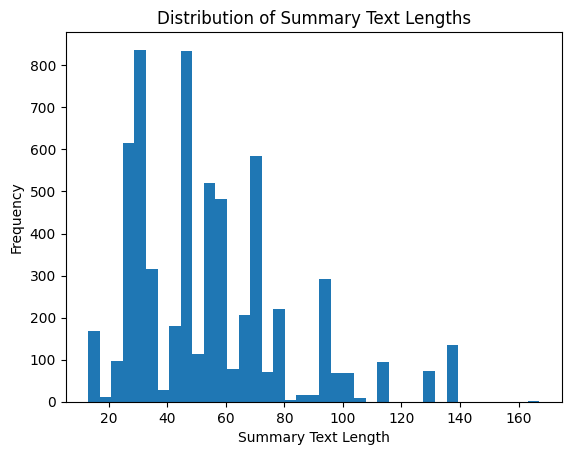

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'ctext' is your text column
# df = pd.DataFrame(...)

# Calculate the length of each text in the 'ctext' column
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

# Plot the distribution of text lengths
plt.hist(df['text_length'], bins='auto') # 'auto' allows matplotlib to choose the number of bins optimally
plt.title('Distribution of Summary Text Lengths')
plt.xlabel('Summary Text Length')
plt.ylabel('Frequency')
plt.show()

/var/folders/k9/w33jch99031byvrz4c83qqgm0000gn/T/ipykernel_43449/1199738667.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_tokens'] = df['text'].apply(lambda x: len(str(x).split()))


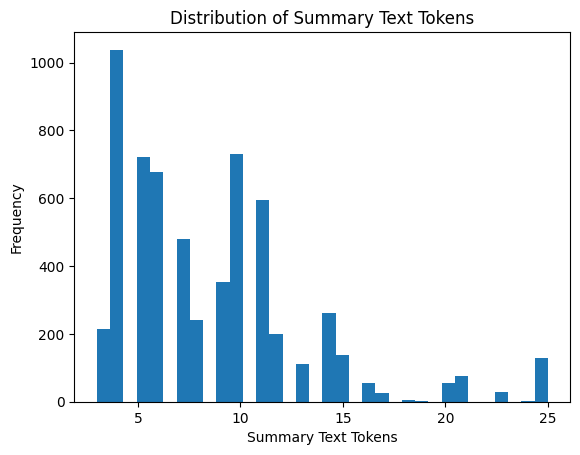

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'ctext' is your text column
# df = pd.DataFrame(...)

# Calculate the number of tokens in each text in the 'ctext' column
df['num_tokens'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of text lengths
plt.hist(df['num_tokens'], bins='auto') # 'auto' allows matplotlib to choose the number of bins optimally
plt.title('Distribution of Summary Text Tokens')
plt.xlabel('Summary Text Tokens')
plt.ylabel('Frequency')
plt.show()

In [9]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_summarization_capstone_t5large_full_dataset")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    # config.SUMMARY_LEN = 150
    config.SUMMARY_LEN = 30

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-large")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    #df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
    df = pd.read_csv('data/complaints2_prepped.csv',encoding='latin-1')

    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-large")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        #final_df.to_csv('./models/predictions.csv')
        final_df.to_csv('models/complaints2_predictions_t5large_full_dataset.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
df_output = pd.read_csv('models/complaints2_predictions_t5large_full_dataset.csv',encoding='latin-1')

# Assuming df is your DataFrame with 'Actual Text' and 'Generated Text' columns

from bert_score import score
cands = df_output['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")

# T5-3b
## Full dataset

In [ ]:
def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_summarization_capstone_t5-3b_full_dataset")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 2    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 2    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 2        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    # config.SUMMARY_LEN = 150
    config.SUMMARY_LEN = 30

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-3b")


    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only.
    # Adding the summarzie text in front of the text. This is to format the dataset similar to how T5 model was trained for summarization task.
    #df = pd.read_csv('./data/news_summary.csv',encoding='latin-1')
    df = pd.read_csv('data/complaints2_prepped.csv',encoding='latin-1')

    df = df[['text','ctext']]
    df.ctext = 'summarize: ' + df.ctext
    print(df.head())


    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation.
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)



    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = T5ForConditionalGeneration.from_pretrained("t5-3b")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        #final_df.to_csv('./models/predictions.csv')
        final_df.to_csv('models/complaints2_predictions_t5 3b_full_dataset.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

In [ ]:
df_output = pd.read_csv('models/complaints2_predictions_t5 3b_full_dataset.csv',encoding='latin-1')

# Assuming df is your DataFrame with 'Actual Text' and 'Generated Text' columns

from bert_score import score
cands = df_output['Generated Text'].tolist() # Candidate (generated) sentences
refs = df_output['Actual Text'].tolist() # Reference (actual) sentences

P, R, F1 = score(cands, refs, lang='en', verbose=True)

print(f"Precision: {P.mean()}")
print(f"Recall: {R.mean()}")
print(f"F1 Score: {F1.mean()}")